<a href="https://colab.research.google.com/github/mcnica89/DATA6100_F23/blob/main/PCA/PCA_for_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf # R-style formula api

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import statsmodels.api as sm
np.random.seed(42)

# Make some highly correlated data

In [ ]:
#Secret data generation!!
def secret_data(N):
  X_1 = np.random.randn(N)
  a = 0.9
  X_2 = a*X_1 + np.sqrt(1-a**2)*np.random.randn(N)
  X_3 = a*X_2 + np.sqrt(1-a**2)*np.random.randn(N)
  X_4 = a*X_3 + np.sqrt(1-a**2)*np.random.randn(N)
  X_5 = a*X_4 + np.sqrt(1-a**2)*np.random.randn(N)

  b = 2
  ep = 1
  Y_1 = b*X_1 + ep*np.random.randn(N)
  Y_2 = b*(X_2+X_3+X_4+X_5)/np.sqrt(4) + ep*np.random.randn(N)
  return X_1,X_2,X_3,X_4,X_5,Y_1,Y_2

N = 150
X_1,X_2,X_3,X_4,X_5,Y_1,Y_2 = secret_data(N)

In [ ]:
df = pd.DataFrame({'X_1':X_1,'X_2':X_2,'X_3':X_3,'X_4':X_4, 'X_5':X_5, 'Y_1':Y_1, 'Y_2':Y_2})
df.head()

,X_1,X_2,X_3,X_4,X_5,Y_1,Y_2
0,0.496714,0.556230,0.139256,0.098010,0.418172,0.070195,1.580342
1,-0.138264,0.026575,-0.220259,0.218103,-0.205669,-1.628213,-0.574589
2,0.647689,0.286504,0.583591,0.095564,0.465060,0.319504,1.459464
3,1.523030,1.471964,1.590822,1.651448,2.077212,4.099702,8.069898
4,-0.234153,-0.082991,-0.083802,-0.306556,-0.095688,-1.417706,-0.377939


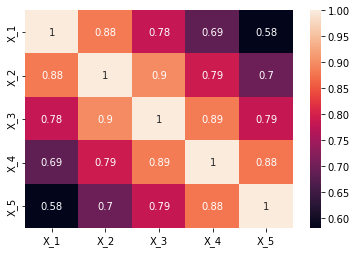

In [ ]:
corr_matrix = df[['X_1', 'X_2','X_3','X_4','X_5']].corr()
sns.heatmap(corr_matrix, annot=True)
plt.show()

#Multiple Linear Regression

# Pre-selecting variables based on correlation (or any other criteria)


In [ ]:
#If you delete all variables correlated with >0.7, then you end up with only X_1
# ols model with intercept

def single_var_regression(my_X,my_Y,df=df):
  my_test_size = 0.2
  df_train, df_test = train_test_split(df, test_size=my_test_size)

  Y_vs_X_model = smf.ols(formula= my_Y + ' ~ ' + my_X, data=df_train)

  #_ fitted model and summary
  Y_vs_X_fit = Y_vs_X_model.fit()
  print(f"Train set size = {int((1-my_test_size)*N)}")
  print(f"Test set size = {int(my_test_size*N)}")


  test_preds = Y_vs_X_fit.predict(df_test)
  MSE = np.mean( (df_test[my_Y] - test_preds)**2 )
  print(f"Test validation RMSE = { np.sqrt(MSE) }")


  #print(Y_vs_X_fit.summary())

  ## Plot it
  X1_axis = np.linspace(-4,4,100)
  Y1_pred = Y_vs_X_fit.predict(pd.DataFrame({my_X:X1_axis}))
  plt.plot(df_train[my_X],df_train[my_Y],'o',label='Train data')
  plt.plot(df_test[my_X],df_test[my_Y],'o',label='Test data')
  plt.plot(X1_axis,Y1_pred,'-',label=f'Lin. fit RMSE={np.sqrt(MSE):.3f}')
  plt.title(f"Single Variable Regression: {my_Y} vs {my_X}")
  plt.xlabel(my_X)
  plt.ylabel(my_Y)
  plt.legend()


## Y_1 vs X_1

Train set size = 120
Test set size = 30
Test validation RMSE = 0.9534320190675457


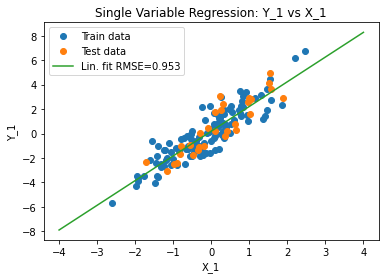

In [ ]:
single_var_regression(my_X = 'X_1',my_Y = 'Y_1')

## Y_2 vs X_1

Train set size = 120
Test set size = 30
Test validation RMSE = 2.0260542806074886


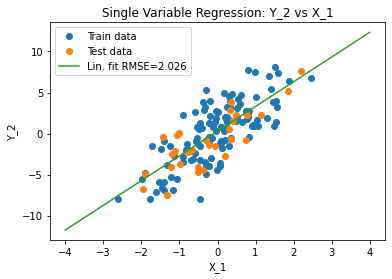

In [ ]:
single_var_regression(my_X = 'X_1',my_Y = 'Y_2')

# Forward variable selection

In [ ]:

def forward_subset_selection(X,y,my_test_size=0.5):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=my_test_size, random_state=3)

  def processSubset(feature_set, X_train, y_train, X_test, y_test):
      # Fit model on feature_set and calculate RSS
      model = sm.OLS(y_train,X_train[list(feature_set)])
      regr = model.fit()
      RMSE = np.sqrt( np.mean((regr.predict(X_test[list(feature_set)]) - y_test) ** 2) )
      return {'features':feature_set, 'model':regr, 'RMSE':RMSE}

  def forward(predictors, X_train, y_train, X_test, y_test):

      # Pull out predictors we still need to process
      remaining_predictors = [p for p in X_train.columns if p not in predictors]

      results = []

      for p in remaining_predictors:
          results.append(processSubset(predictors+[p], X_train, y_train, X_test, y_test))

      # Wrap everything up in a nice dataframe
      models = pd.DataFrame(results)
      print("----Models tried in this round----\n", models[['features','RMSE']] )

      # Choose the model with the highest RSS
      best_model = models.loc[models['RMSE'].argmin()]

      # Return the best model, along with some other useful information about the model
      return best_model

  models_train = pd.DataFrame(columns=['RMSE', 'model'])

  predictors = []

  for i in range(1,len(X.columns)+1):
      models_train.loc[i] = forward(predictors, X_train, y_train, X_test, y_test)
      predictors = models_train.loc[i]['model'].model.exog_names

  plt.plot(models_train['RMSE'],'ob')
  plt.xlabel('# Predictors')
  plt.ylabel('RMSE')

  best_n_vars = models_train['RMSE'].argmin()+1
  best_RMSE = models_train['RMSE'].min()
  #Note: the plus 1 accounts for starting at 0 vs at 1 in the indexing
  plt.plot(best_n_vars, best_RMSE, 'or');
  plt.title(f"Best #Vars = {best_n_vars}")
  print("==========")
  print(f"Best number of vars found: {best_n_vars}")
  print(f"Best model found: {models_train.loc[best_n_vars]['model'].model.exog_names}")

#Y_1 subset selection

----Models tried in this round----
   features      RMSE
0    [X_1]  1.087479
1    [X_2]  1.425349
2    [X_3]  1.504895
3    [X_4]  1.665375
4    [X_5]  1.771373
----Models tried in this round----
      features      RMSE
0  [X_1, X_2]  1.098479
1  [X_1, X_3]  1.109613
2  [X_1, X_4]  1.098011
3  [X_1, X_5]  1.109878
----Models tried in this round----
           features      RMSE
0  [X_1, X_4, X_2]  1.102802
1  [X_1, X_4, X_3]  1.102338
2  [X_1, X_4, X_5]  1.106236
----Models tried in this round----
                features      RMSE
0  [X_1, X_4, X_3, X_2]  1.093749
1  [X_1, X_4, X_3, X_5]  1.109959
----Models tried in this round----
                     features      RMSE
0  [X_1, X_4, X_3, X_2, X_5]  1.101523
Best number of vars found: 1
Best model found: ['X_1']


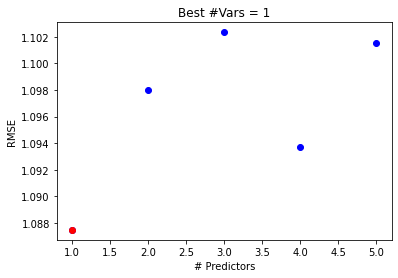

In [ ]:
X = df.iloc[:, 0:5] #X_1 to X_5
Y_1 = df.iloc[:, 5] #Y_1
forward_subset_selection(X,Y_1)

# Y_2 Selection

----Models tried in this round----
   features      RMSE
0    [X_1]  2.340443
1    [X_2]  1.696376
2    [X_3]  1.464689
3    [X_4]  1.389939
4    [X_5]  1.727119
----Models tried in this round----
      features      RMSE
0  [X_4, X_1]  1.212710
1  [X_4, X_2]  1.119604
2  [X_4, X_3]  1.199684
3  [X_4, X_5]  1.304170
----Models tried in this round----
           features      RMSE
0  [X_4, X_2, X_1]  1.127617
1  [X_4, X_2, X_3]  1.106830
2  [X_4, X_2, X_5]  0.999107
----Models tried in this round----
                features      RMSE
0  [X_4, X_2, X_5, X_1]  1.012357
1  [X_4, X_2, X_5, X_3]  0.991700
----Models tried in this round----
                     features      RMSE
0  [X_4, X_2, X_5, X_3, X_1]  1.012846
Best number of vars found: 4
Best model found: ['X_4', 'X_2', 'X_5', 'X_3']


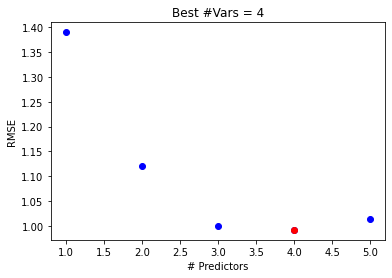

In [ ]:
X = df.iloc[:, 0:5] #X_1 to X_5
Y_2 = df.iloc[:, 6] #Y_2
forward_subset_selection(X,Y_2)

# Doing it with PCA

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=5)
X = np.column_stack((X_1,X_2,X_3,X_4,X_5))
pca.fit(X)
print("Variance ratio of components:\n",pca.explained_variance_ratio_)


Variance ratio of components:
 [0.83072847 0.10667634 0.03120942 0.01890257 0.0124832 ]


In [ ]:
PCA_X = pca.transform(X)
PCA_df = pd.DataFrame({'PCA_1':PCA_X[:,0],'PCA_2':PCA_X[:,1],'PCA_3':PCA_X[:,2],'PCA_4':PCA_X[:,3], 'PCA_5':PCA_X[:,4], 'Y_1':Y_1, 'Y_2':Y_2})
PCA_df.head()

,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,Y_1,Y_2
0,0.874346,-0.205287,0.324937,-0.228274,-0.108573,0.070195,1.580342
1,-0.027896,0.019786,-0.030748,0.194922,-0.323700,-1.628213,-0.574589
2,1.042061,-0.173947,0.212672,-0.074303,0.370762,0.319504,1.459464
3,3.818595,0.435182,0.422348,-0.034136,0.087730,4.099702,8.069898
4,-0.238995,-0.001389,-0.010054,-0.182887,0.049133,-1.417706,-0.377939


## Y_1 vs PCA_1

Train set size = 120
Test set size = 30
Test validation RMSE = 1.4546976035000938


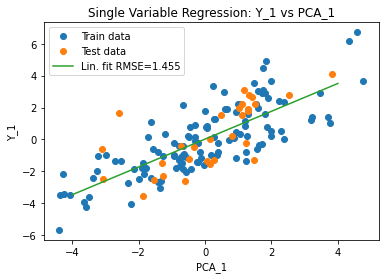

In [ ]:
single_var_regression(my_X = 'PCA_1',my_Y = 'Y_1', df=PCA_df)

## Y_2 vs PCA_1

Train set size = 120
Test set size = 30
Test validation RMSE = 1.1557426567454487


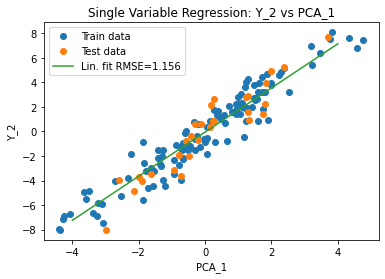

In [ ]:
single_var_regression(my_X = 'PCA_1',my_Y = 'Y_2', df=PCA_df)

# Subset selection with PCA variables

## Y_1 vs PCA

----Models tried in this round----
   features      RMSE
0  [PCA_1]  1.381896
1  [PCA_2]  2.028606
2  [PCA_3]  2.018302
3  [PCA_4]  2.034179
4  [PCA_5]  2.048850
----Models tried in this round----
          features      RMSE
0  [PCA_1, PCA_2]  1.159226
1  [PCA_1, PCA_3]  1.315365
2  [PCA_1, PCA_4]  1.370868
3  [PCA_1, PCA_5]  1.341834
----Models tried in this round----
                 features      RMSE
0  [PCA_1, PCA_2, PCA_3]  1.094209
1  [PCA_1, PCA_2, PCA_4]  1.157793
2  [PCA_1, PCA_2, PCA_5]  1.107549
----Models tried in this round----
                        features      RMSE
0  [PCA_1, PCA_2, PCA_3, PCA_4]  1.107206
1  [PCA_1, PCA_2, PCA_3, PCA_5]  1.038367
----Models tried in this round----
                               features      RMSE
0  [PCA_1, PCA_2, PCA_3, PCA_5, PCA_4]  1.051645
Best number of vars found: 4
Best model found: ['PCA_1', 'PCA_2', 'PCA_3', 'PCA_5']


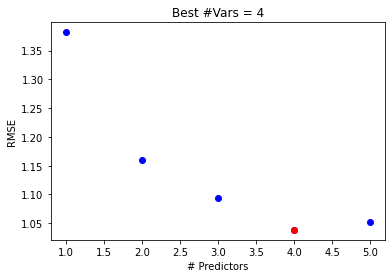

In [ ]:
PCA_X = PCA_df.iloc[:, 0:5] #PCA_1 to PCA_5
Y_1 = PCA_df.iloc[:, 5] #Y_1
forward_subset_selection(PCA_X,Y_1)

## Y_2 vs PCA

----Models tried in this round----
   features      RMSE
0  [PCA_1]  0.959628
1  [PCA_2]  3.528614
2  [PCA_3]  3.572088
3  [PCA_4]  3.589795
4  [PCA_5]  3.664875
----Models tried in this round----
          features      RMSE
0  [PCA_1, PCA_2]  0.970065
1  [PCA_1, PCA_3]  0.982447
2  [PCA_1, PCA_4]  0.980783
3  [PCA_1, PCA_5]  0.962329
----Models tried in this round----
                 features      RMSE
0  [PCA_1, PCA_5, PCA_2]  0.971389
1  [PCA_1, PCA_5, PCA_3]  0.983431
2  [PCA_1, PCA_5, PCA_4]  0.983188
----Models tried in this round----
                        features      RMSE
0  [PCA_1, PCA_5, PCA_2, PCA_3]  1.000388
1  [PCA_1, PCA_5, PCA_2, PCA_4]  0.968837
----Models tried in this round----
                               features      RMSE
0  [PCA_1, PCA_5, PCA_2, PCA_4, PCA_3]  0.997459
Best number of vars found: 1
Best model found: ['PCA_1']


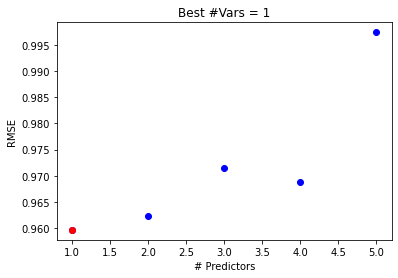

In [ ]:
PCA_X = PCA_df.iloc[:, 0:5] #PCA_1 to PCA_5
Y_2 = PCA_df.iloc[:, 6] #Y_1
forward_subset_selection(PCA_X,Y_2)